Set up:

In [2]:
%load_ext sql


In [3]:
%sql postgresql://appdev@data/appdev


'Connected: appdev@appdev'

In [7]:
%matplotlib inline

## Assignment 8: Spatial data and Magic: The gathering

*Deadline: 10th of April 12:00*

*Review deadline: 11th of April 23:59*

This assignment is split into two parts: a spatial part and a JSON parsing part

### 1. In the first part you'll be processing the data in the geonames table.

##### A. Find the tuple with the largest population

Two ways to select max. 

Created point type as max_point

In [31]:
%sql SELECT * FROM geonames WHERE population IN (SELECT MAX(population) FROM geonames);

1 rows affected.


geonameid,name,longitude,latitude,feature_class,feature_code,country_code,admin1_code,admin2_code,population,elevation,timezone
305104,Levant,36.0,34.0,L,RGN,None,None,None,44990000,None,Asia/Beirut


In [6]:
%%sql 
DROP VIEW IF EXISTS maximum_population_geonames;
CREATE VIEW maximum_population_geonames AS SELECT *, point(longitude,latitude) AS max_point FROM  geonames order by population DESC LIMIT 1;
SELECT * FROM maximum_population_geonames;

Done.
Done.
1 rows affected.


geonameid,name,longitude,latitude,feature_class,feature_code,country_code,admin1_code,admin2_code,population,elevation,timezone,max_point
305104,Levant,36.0,34.0,L,RGN,None,None,None,44990000,None,Asia/Beirut,"(36,34)"


##### B. Now calculate the distance from all locations to the tuple above using the <-> function

I put an intentional limit to 10. See full results in the end.

In [7]:
%sql SELECT name, longitude, latitude, point(latitude, longitude) <-> (SELECT max_point FROM maximum_population_geonames) AS distance FROM  geonames order by distance LIMIT 10;

10 rows affected.


name,longitude,latitude,distance
Mazi İni,33.88903,36.46384,0.476929645230822
Ágios Geórgios Sakkás,34.24257,35.55606,0.505888256930321
Mazoulia,34.1086,35.48976,0.521669260739028
Melánarga,34.19685,35.5147,0.523704126869363
Platanissós,34.10682,35.47866,0.532170938702972
Trapezoulli,34.00833,35.44583,0.554232602613739
Varkes,34.00417,35.40833,0.591684694579808
Yaroluğu Çeşmesi,33.54263,36.41497,0.617565719417776
Çiriş,34.21298,36.62601,0.661248062757088
Phourni Rock,33.7,35.38333,0.68577101783321


##### C. Now calculate the distance from all locations to the tuple above using the haversine distance

##### a. The haversine distance has been implemented in PL/PGSQL here: https://gist.github.com/carlzulauf/1724506



In [35]:
%%sql -- Haversine Formula based geodistance in miles (constant is diameter of Earth in miles)
-- Based on a similar PostgreSQL function found here: https://gist.github.com/831833
-- Updated to use distance formulas found here: http://www.codecodex.com/wiki/Calculate_distance_between_two_points_on_a_globe
CREATE OR REPLACE FUNCTION public.geodistance(alat double precision, alng double precision, blat double precision, blng double precision)
  RETURNS double precision AS
$BODY$
SELECT asin(
  sqrt(
    sin(radians($3-$1)/2)^2 +
    sin(radians($4-$2)/2)^2 *
    cos(radians($1)) *
    cos(radians($3))
  )
) * 7926.3352 AS distance;
$BODY$
  LANGUAGE sql IMMUTABLE
  COST 100;

Done.


[]

Limited by 10

In [37]:
%sql SELECT name, longitude, latitude, geodistance(latitude, longitude,(SELECT latitude FROM maximum_population_geonames),(SELECT longitude FROM maximum_population_geonames)) AS distance FROM  geonames order by distance LIMIT 10;

10 rows affected.


name,longitude,latitude,distance
Levant,36.0,34.0,0.0
Ard Taraya,35.9925,33.98944,0.847665920176457
Njâsset el Aaoujâ,35.96167,33.98889,2.32862951484646
El Mâred,35.95972,33.96028,3.58975612444631
Machraa Tem el Qboûr,35.92056,34.0075,4.58471478448574
Dahr Ouâdi ed Dabboûr,35.94833,34.07583,6.02358133600656
Ed Darjé,35.89139,33.99583,6.23504633900297
Sahlêt el Bayâder,35.99861,33.90972,6.24520603564188
Dahr el Qadîb,35.93333,33.91111,7.2413146715482
Qabr ed Derzi,35.93472,33.90139,7.7816636557647


##### D. Plot the latitude and longitude of the largest 1000 populations on a 2-D scatter plot. 
##### b. You can use IPython-SQL or Pandas to create the plot

In [40]:
%%sql 
DROP VIEW IF EXISTS largest_populations;
CREATE VIEW largest_populations AS 
SELECT latitude, longitude, population FROM geonames ORDER BY population DESC LIMIT 1000;

Done.
Done.


[]

1000 rows affected.


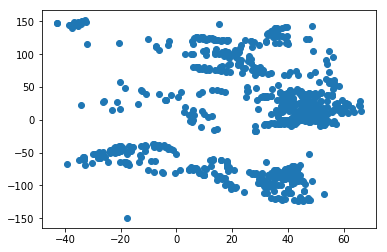

In [42]:
import matplotlib.pyplot as plt


res = %sql SELECT latitude, longitude FROM largest_populations;

lat,lon = zip(*res)

plt.scatter(lat,lon)
plt.show()

### 2. In the second part your job is to work with JSON data from the magic schema. The schema is based on the game Magic: The gathering

##### A. Find all the cards that is made by Rob Alexander

I limit to 10 here

In [4]:
%sql SELECT data FROM cards WHERE data @> '{"artist":"Rob Alexander"}' LIMIT 1;

1 rows affected.


data
"{'id': '4a7bf234af44e07d9a159d4d89e96ce320919917', 'cmc': 6, 'name': 'Beacon of Immortality', 'text': ""Double target player's life total. Shuffle Beacon of Immortality into its owner's library."", 'type': 'Instant', 'types': ['Instant'], 'artist': 'Rob Alexander', 'colors': ['White'], 'flavor': 'The cave floods with light. A thousand rays shine forth and meld into one.', 'layout': 'normal', 'number': '10', 'rarity': 'Rare', 'manaCost': '{5}{W}', 'imageName': 'beacon of immortality', 'mciNumber': '10', 'multiverseid': 130553, 'colorIdentity': ['W']}"


##### B. Find all the cards that have the subtype "Human"

I limit to 10 here.


In [55]:
%sql SELECT data FROM cards WHERE data->>'subtypes' LIKE '%Human%' LIMIT 1;

1 rows affected.


data
"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"


In [56]:
%sql SELECT data FROM cards WHERE data @> '{"subtypes":["Human"]}' LIMIT 1;


1 rows affected.


data
"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"


##### C. Group all the cards based on the colour. Aggregate them by counting the number of cards per colour.


All color combinations:

32 rows affected.


<Container object of 32 artists>

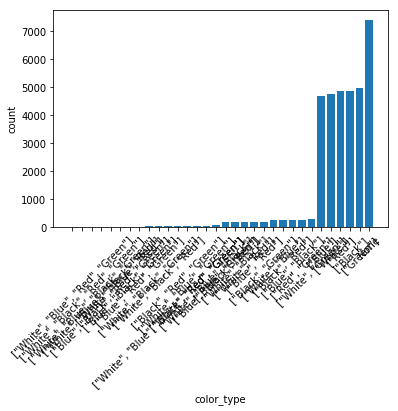

In [9]:
res = %sql SELECT data->>'colors' AS color_type, count(*) FROM cards GROUP BY color_type order by count;
res.bar()

More correct only the base colors/colours:

In [52]:
%%sql DROP VIEW IF EXISTS colors_cards; 
CREATE VIEW colors_cards AS SELECT jsonb_array_elements(data -> 'colors') AS color_type, count(*) FROM cards GROUP BY color_type ORDER BY count;
SELECT * FROM colors_cards;


Done.
Done.
5 rows affected.


color_type,count
Blue,5836
White,5920
Red,6054
Black,6067
Green,6162


5 rows affected.


<Container object of 5 artists>

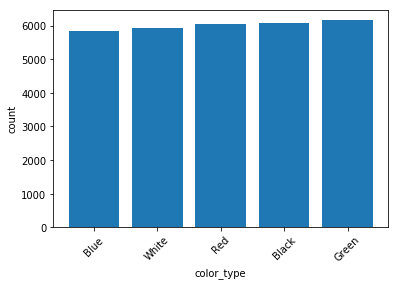

In [53]:
import matplotlib

res = %sql SELECT * FROM colors_cards ORDER BY count;
res.bar()

## No limit ...

In [ ]:
%sql SELECT name, longitude, latitude, point(latitude, longitude) <-> (SELECT max_point FROM maximum_population_geonames) AS distance FROM  geonames order by distance;

In [ ]:
%sql SELECT name, longitude, latitude, geodistance(latitude, longitude,(SELECT latitude FROM maximum_population_geonames),(SELECT longitude FROM maximum_population_geonames)) AS distance FROM  geonames order by distance LIMIT 10;

In [5]:
%sql SELECT data FROM cards WHERE data @> '{"subtypes":["Human"]}';


3192 rows affected.


data
"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"
"{'id': 'd3488c0a916bd922856473155a8b49ec23fc2217', 'cmc': 4, 'name': 'Ballista Squad', 'text': '{X}{W}, {T}: Ballista Squad deals X damage to target attacking or blocking creature.', 'type': 'Creature — Human Rebel', 'power': '2', 'types': ['Creature'], 'artist': 'Matthew D. Wilson', 'colors': ['White'], 'flavor': 'The perfect antidote for a tightly packed formation.', 'layout': 'normal', 'number': '8', 'rarity': 'Uncommon', 'manaCost': '{3}{W}', 'subtypes': ['Human', 'Rebel'], 'imageName': 'ballista squad', 'mciNumber': '8', 'toughness': '2', 'multiverseid': 129477, 'colorIdentity': ['W']}"
"{'id': '29c46fca29e5de01dba3bbf05393325bc9132735', 'cmc': 3, 'name': 'Benalish Knight', 'text': 'Flash (You may cast this spell any time you could cast an instant.)\nFirst strike (This creature deals combat damage before creatures without first strike.)', 'type': 'Creature — Human Knight', 'power': '2', 'types': ['Creature'], 'artist': 'Zoltan Boros & Gabor Szikszai', 'colors': ['White'], 'flavor': '""We called them \'armored lightning.\'""\n—Gerrard of the Weatherlight', 'layout': 'normal', 'number': '11', 'rarity': 'Common', 'manaCost': '{2}{W}', 'subtypes': ['Human', 'Knight'], 'imageName': 'benalish knight', 'mciNumber': '11', 'toughness': '2', 'multiverseid': 136279, 'colorIdentity': ['W']}"
"{'id': 'e8b8dea65daf4e9070cce5de62bdbea0bf36d47c', 'cmc': 4, 'name': 'Cho-Manno, Revolutionary', 'text': 'Prevent all damage that would be dealt to Cho-Manno, Revolutionary.', 'type': 'Legendary Creature — Human Rebel', 'power': '2', 'types': ['Creature'], 'artist': 'Steven Belledin', 'colors': ['White'], 'flavor': '""Mercadia\'s masks can no longer hide the truth. Our day has come at last.""', 'layout': 'normal', 'number': '12', 'rarity': 'Rare', 'manaCost': '{2}{W}{W}', 'subtypes': ['Human', 'Rebel'], 'imageName': 'cho-manno, revolutionary', 'mciNumber': '12', 'toughness': '2', 'supertypes': ['Legendary'], 'multiverseid': 130554, 'colorIdentity': ['W']}"
"{'id': '80a6b907fc380ed97615e8abc0fe6071c4ceef67', 'cmc': 3, 'name': 'Field Marshal', 'text': 'Other Soldier creatures get +1/+1 and have first strike. (They deal combat damage before creatures without first strike.)', 'type': 'Creature — Human Soldier', 'power': '2', 'types': ['Creature'], 'artist': 'Stephen Tappin', 'colors': ['White'], 'flavor': 'He is the only one who sees the patterns in the overlapping maps and conflicting reports.', 'layout': 'normal', 'number': '15', 'rarity': 'Rare', 'manaCost': '{1}{W}{W}', 'subtypes': ['Human', 'Soldier'], 'imageName': 'field marshal', 'mciNumber': '15', 'toughness': '2', 'multiverseid': 135258, 'colorIdentity': ['W']}"
"{'id': '7879b835a2c3d6516515d03bd3a3894dceee1812', 'cmc': 1, 'name': 'Honor Guard', 'text': '{W}: Honor Guard gets +0/+1 until end of turn.', 'type': 'Creature — Human Soldier', 'power': '1', 'types': ['Creature'], 'artist': 'Dan Dos Santos', 'colors': ['White'], 'flavor': 'The strength of one. The courage of ten.', 'layout': 'normal', 'number': '23', 'rarity': 'Common', 'manaCost': '{W}', 'subtypes': ['Human', 'Soldier'], 'imageName': 'honor guard', 'mciNumber': '23', 'toughness': '1', 'multiverseid': 129595, 'colorIdentity': ['W']}"
"{'id': '55932565b6905650e67e784b7cf0df63990e9851', 'cmc': 1, 'name': 'Icatian Priest', 'text': '{1}{W}{W}: T